### Globals

In [2]:
import datetime

tauri_onnx_models_directory = "../SonicSearch/src-tauri/onnx_models/"
file_timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = "laion/clap-htsat-unfused"

### Utilities

In [3]:
# Utilities
import time

def make_filename_or_dirname(filename, extension=None):
    extension = "" if extension is None else "." + extension.strip('.')
    filename = filename.strip('.').lstrip('/')
    return f'{tauri_onnx_models_directory}{filename}{extension}'

# Inspect inputs and outputs
def get_shapes_in_nests(node, count=0):
    try:
        return str(node.shape)
    except:
        count += 1
        try:
            return ('\n' + '\t'*count).join([f'{key}: {get_shapes_in_nests(value)}' for key, value in node.items()])
        except:
            if isinstance(node, list):
                return ('\n' + '\t'*count).join([get_shapes_in_nests(n) for n in node])
            else:
                return str(node)
        
class QuickTimer():
    """hahaha"""
    _start = 0
    
    def start():
        QuickTimer._start = time.time()
    
    def stop():
        return time.time() - QuickTimer._start

## Embedders: Audio + Text Model with Projection

### Text

In [4]:
from transformers import AutoTokenizer, ClapTextModelWithProjection


text_model = ClapTextModelWithProjection.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_inputs = tokenizer(["the longest input one would reasonably use. Truly just one loooooooong input :)."], padding=True, return_tensors="pt")

text_model_outputs = text_model(**tokenized_inputs)
text_embeds = text_model_outputs.text_embeds

Some weights of the model checkpoint at laion/clap-htsat-unfused were not used when initializing ClapTextModelWithProjection: ['audio_model.audio_encoder.layers.2.blocks.2.output.dense.weight', 'audio_model.audio_encoder.layers.0.blocks.1.layernorm_after.bias', 'audio_model.audio_encoder.layers.0.blocks.0.layernorm_after.weight', 'audio_model.audio_encoder.layers.2.blocks.4.attention.self.relative_position_index', 'audio_model.audio_encoder.layers.0.blocks.1.intermediate.dense.bias', 'audio_model.audio_encoder.layers.0.blocks.1.output.dense.bias', 'audio_model.audio_encoder.layers.0.blocks.1.layernorm_before.weight', 'audio_model.audio_encoder.layers.0.blocks.0.attention.self.key.bias', 'audio_model.audio_encoder.layers.2.blocks.1.intermediate.dense.bias', 'audio_model.audio_encoder.layers.2.blocks.5.attention.self.relative_position_bias_table', 'logit_scale_t', 'audio_model.audio_encoder.layers.2.blocks.5.attention.output.dense.weight', 'audio_model.audio_encoder.layers.2.blocks.3.att

In [5]:
# Text inputs and outputs

print("Inputs: ", get_shapes_in_nests(tokenized_inputs))
print("Outputs: ", get_shapes_in_nests(text_model_outputs))

Inputs:  input_ids: torch.Size([1, 20])
	attention_mask: torch.Size([1, 20])
Outputs:  text_embeds: torch.Size([1, 512])
	last_hidden_state: torch.Size([1, 20, 768])


In [6]:
# Onnx Export - Text Model with projection

from torch import onnx

print("Exporting tokenizer config...")
tokenizer.save_pretrained(make_filename_or_dirname("tokenizer"))

print("Exporting model to ONNX...")
QuickTimer.start()
onnx.export(
    text_model,
    (tokenized_inputs["input_ids"], tokenized_inputs["attention_mask"]),
    make_filename_or_dirname(f"{model_name.split('/')[-1]}_text_with_projection", "onnx"),
    export_params=True,
    input_names=["input_ids", "attention_mask"],
    output_names=["text_embeds", "last_hidden_state"]
    
)
print("Exporting model to ONNX took: ", QuickTimer.stop())

Exporting tokenizer config...
Exporting model to ONNX...
Exporting model to ONNX took:  2.2707037925720215


### Audio

In [8]:
from datasets import load_dataset
from transformers import ClapAudioModelWithProjection, ClapProcessor
import numpy as np

audio_model = ClapAudioModelWithProjection.from_pretrained(model_name)
processor = ClapProcessor.from_pretrained(model_name)

dataset = load_dataset("ashraq/esc50")
audio_sample = [datum["array"] for datum in dataset["train"]["audio"][0:31]]
longer_sample = np.concatenate(np.array([datum["array"] for datum in dataset["train"]["audio"][32:34]]))
audio_sample.append(longer_sample)

audio_inputs = processor(audios=audio_sample, return_tensors="pt", sampling_rate=48000)
audio_outputs = audio_model(**audio_inputs)
audio_embeds = audio_outputs.audio_embeds

Some weights of the model checkpoint at laion/clap-htsat-unfused were not used when initializing ClapAudioModelWithProjection: ['text_model.encoder.layer.2.attention.output.LayerNorm.weight', 'text_model.encoder.layer.7.output.LayerNorm.weight', 'text_model.encoder.layer.11.attention.self.query.bias', 'text_model.encoder.layer.11.attention.self.value.bias', 'text_model.encoder.layer.6.attention.self.query.weight', 'text_model.encoder.layer.7.attention.output.dense.weight', 'text_model.encoder.layer.1.attention.self.query.weight', 'text_model.encoder.layer.3.attention.output.dense.weight', 'logit_scale_t', 'text_model.encoder.layer.1.attention.output.dense.bias', 'text_model.encoder.layer.2.attention.output.dense.weight', 'text_model.encoder.layer.8.attention.self.query.weight', 'text_model.encoder.layer.8.output.LayerNorm.weight', 'text_model.encoder.layer.2.attention.self.key.weight', 'text_model.encoder.layer.8.output.dense.bias', 'text_model.encoder.layer.10.output.dense.bias', 'tex

In [9]:
# Audio inputs and outputs

print("Inputs: ", get_shapes_in_nests(audio_inputs))
print("Outputs: ", get_shapes_in_nests(audio_outputs))

Inputs:  input_features: torch.Size([32, 1, 1001, 64])
	is_longer: torch.Size([32, 1])
Outputs:  audio_embeds: torch.Size([32, 512])
	last_hidden_state: torch.Size([32, 768, 2, 32])


In [10]:
# Onnx Export - Audio Model with projection

from torch import onnx

print("Exporting feature extractor config...")
processor.feature_extractor.save_pretrained(make_filename_or_dirname("feature_extractor"))

print("Exporting model to ONNX...")
QuickTimer.start()
onnx.export(
    audio_model,
    (audio_inputs["input_features"], audio_inputs["is_longer"]),
    make_filename_or_dirname(f"{model_name.split('/')[-1]}_audio_with_projection", "onnx"),
    export_params=True,
    input_names=["input_features", "is_longer"],
    output_names=["audio_embeds", "last_hidden_state"]
)
print("Exporting model to ONNX took: ", QuickTimer.stop())

Exporting feature extractor config...
Exporting model to ONNX...


/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/transformers/models/clap/modeling_clap.py:871: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if time_length > spec_width or freq_length > spec_heigth:
/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/transformers/models/clap/modeling_clap.py:875: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if time_length < spec_width:
/Users/iveshenry18/.pyenv/versions/clap_export/lib/python3.11/site-packages/transformers/models/clap/modeling_clap.py:879: TracerWarn

Exporting model to ONNX took:  14.836242914199829


# SCRATCH

## Audio Processor Understanding
My hypothesis: when audio is <10 seconds, and we aren't doing fusion, the preprocessing is simply repeat-padding the values and transforming them to a Mel Spectrogram.

In [11]:
print(get_shapes_in_nests(audio_sample[-5:]))
print(get_shapes_in_nests(audio_inputs["input_features"][-5:]))
print(get_shapes_in_nests(audio_inputs["is_longer"][-5:]))

(220500,)
	(220500,)
	(220500,)
	(220500,)
	(441000,)
torch.Size([5, 1, 1001, 64])
torch.Size([5, 1])


Preprocessed audio_sample shape:  (220500,)


Processed input_features shape:  torch.Size([1, 1001, 64])
Manual processed input_features shape:  torch.Size([1, 1001, 64])


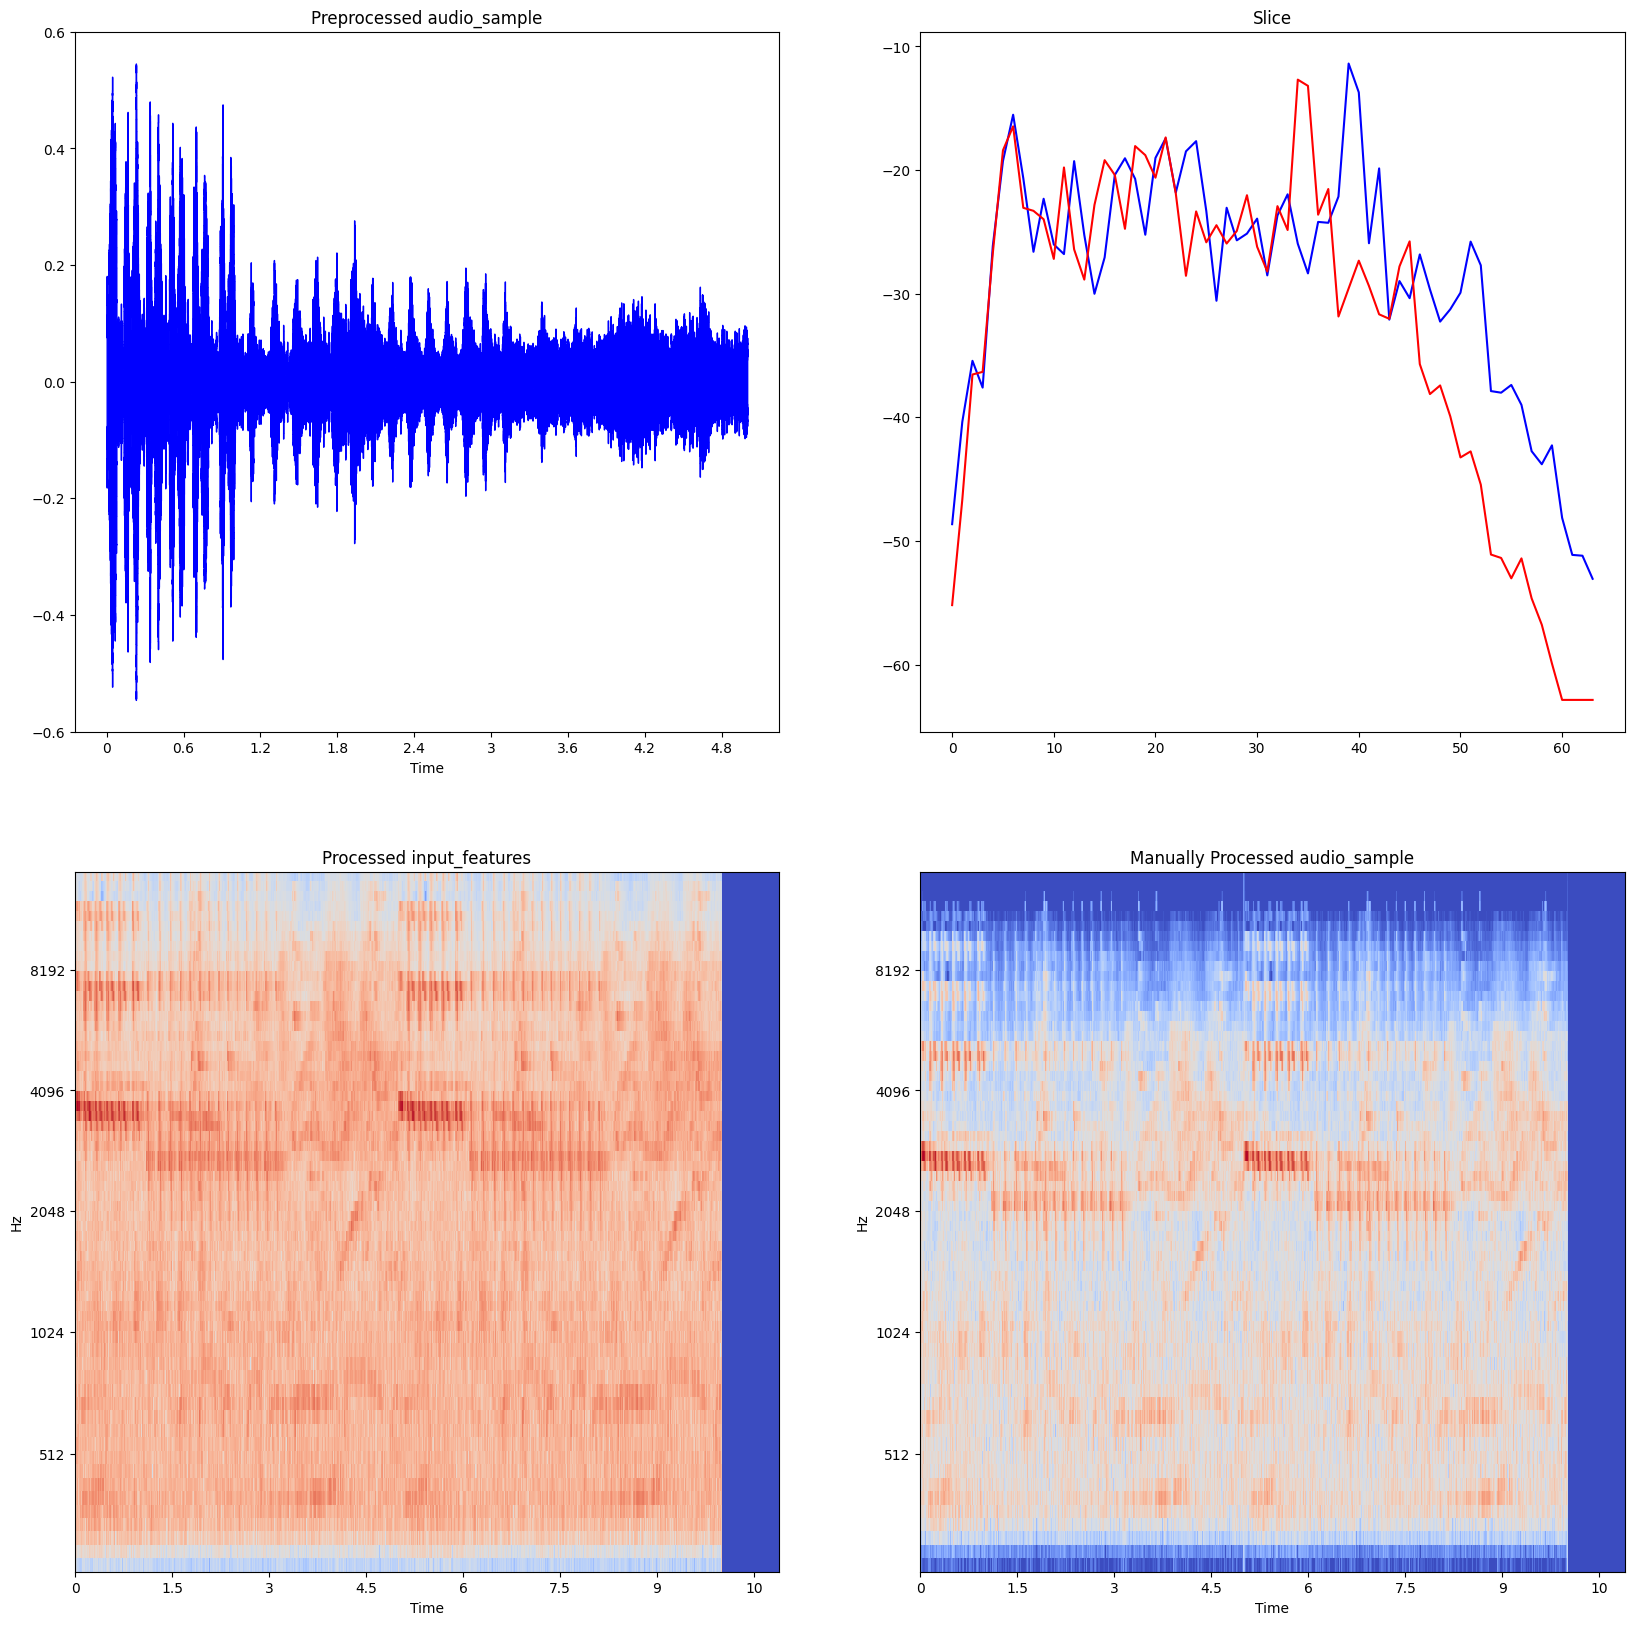

In [19]:
# An attempt to manually reverse-engineer the preprocessing

import librosa
from IPython.display import Audio, display
import torch
import numpy as np

sample_num = 1

librosa.display.plt.figure(figsize=(20, 20))
librosa.display.plt.subplot(2, 2, 1)
librosa.display.plt.title('Preprocessed audio_sample')
print("Preprocessed audio_sample shape: ", audio_sample[sample_num].shape)
display(Audio(data=audio_sample[sample_num], rate=44100))
librosa.display.waveshow(audio_sample[sample_num], sr=44100, color='blue')

librosa.display.plt.subplot(2, 2, 3)
librosa.display.plt.title('Processed input_features')
print("Processed input_features shape: ", audio_inputs["input_features"][sample_num].shape)
specshow_tensor = torch.transpose(audio_inputs["input_features"][sample_num,0], 0, 1).numpy()
librosa.display.specshow(specshow_tensor, sr=44100, x_axis='time', y_axis='mel', hop_length=480, cmap='coolwarm', fmax=14000, fmin=50, n_fft=1024, win_length=1024)

librosa.display.plt.subplot(2, 2, 2)
librosa.display.plt.title('Slice')
librosa.display.plt.plot(specshow_tensor[:, 100], color="blue")


def pad_mel_dbifier(manual_processing_inputs):
    manual_processed_input_features = []
    for manual_processing_input in manual_processing_inputs:
        max_length = 48000 * 10
        assert manual_processing_input.shape[0] <= max_length, "Input is too long"
        if manual_processing_input.shape[0] < max_length:
                    n_repeat = int(max_length / len(manual_processing_input))
                    stacked_manual_processing_input = np.stack(np.tile(manual_processing_input, n_repeat))
                    padded_manual_processing_input = np.pad(stacked_manual_processing_input, (0, max_length - manual_processing_input.shape[0]))
        else:
            padded_manual_processing_input = manual_processing_input
        sample_melled = librosa.feature.melspectrogram(y=padded_manual_processing_input, sr=48000, n_fft=1024, hop_length=480, win_length=1024, window='hann', norm='slaney', n_mels=64, power=2.0) # "mel"
        sample_melled_and_dbed = librosa.power_to_db(sample_melled) # TODO: resulting values look lower; inspect
        manual_processed_input_feature = np.expand_dims(sample_melled_and_dbed.transpose(), 0)
        features_np_array = manual_processed_input_feature[:, :1001, :] # HACkHACkHACkHACk put me in jail
        manual_processed_input_features.append(features_np_array)
        # TODO: trunkation is weird; inspect

    return {"input_features": torch.from_numpy(np.stack(manual_processed_input_features, axis=0)).to(torch.float32), "is_longer": torch.Tensor([False] * len(manual_processing_inputs)).unsqueeze(1).to(torch.bool)}

manual_processed_input_features = pad_mel_dbifier(audio_sample[sample_num-1:sample_num+1]) # slicing for speed :/

librosa.display.plt.subplot(2, 2, 4)
librosa.display.plt.title('Manually Processed audio_sample')
print("Manual processed input_features shape: ", manual_processed_input_features["input_features"][sample_num].shape)
manually_processed_specshow_tensor = torch.transpose(manual_processed_input_features["input_features"][sample_num,0], 0, 1).numpy()
librosa.display.specshow(manually_processed_specshow_tensor, sr=44100, x_axis='time', y_axis='mel', hop_length=480, cmap='coolwarm', fmax=14000, fmin=50, n_fft=1024, win_length=1024)

librosa.display.plt.subplot(2, 2, 2)
librosa.display.plt.plot(manually_processed_specshow_tensor[:, 100], color="red")


librosa.display.plt.show()

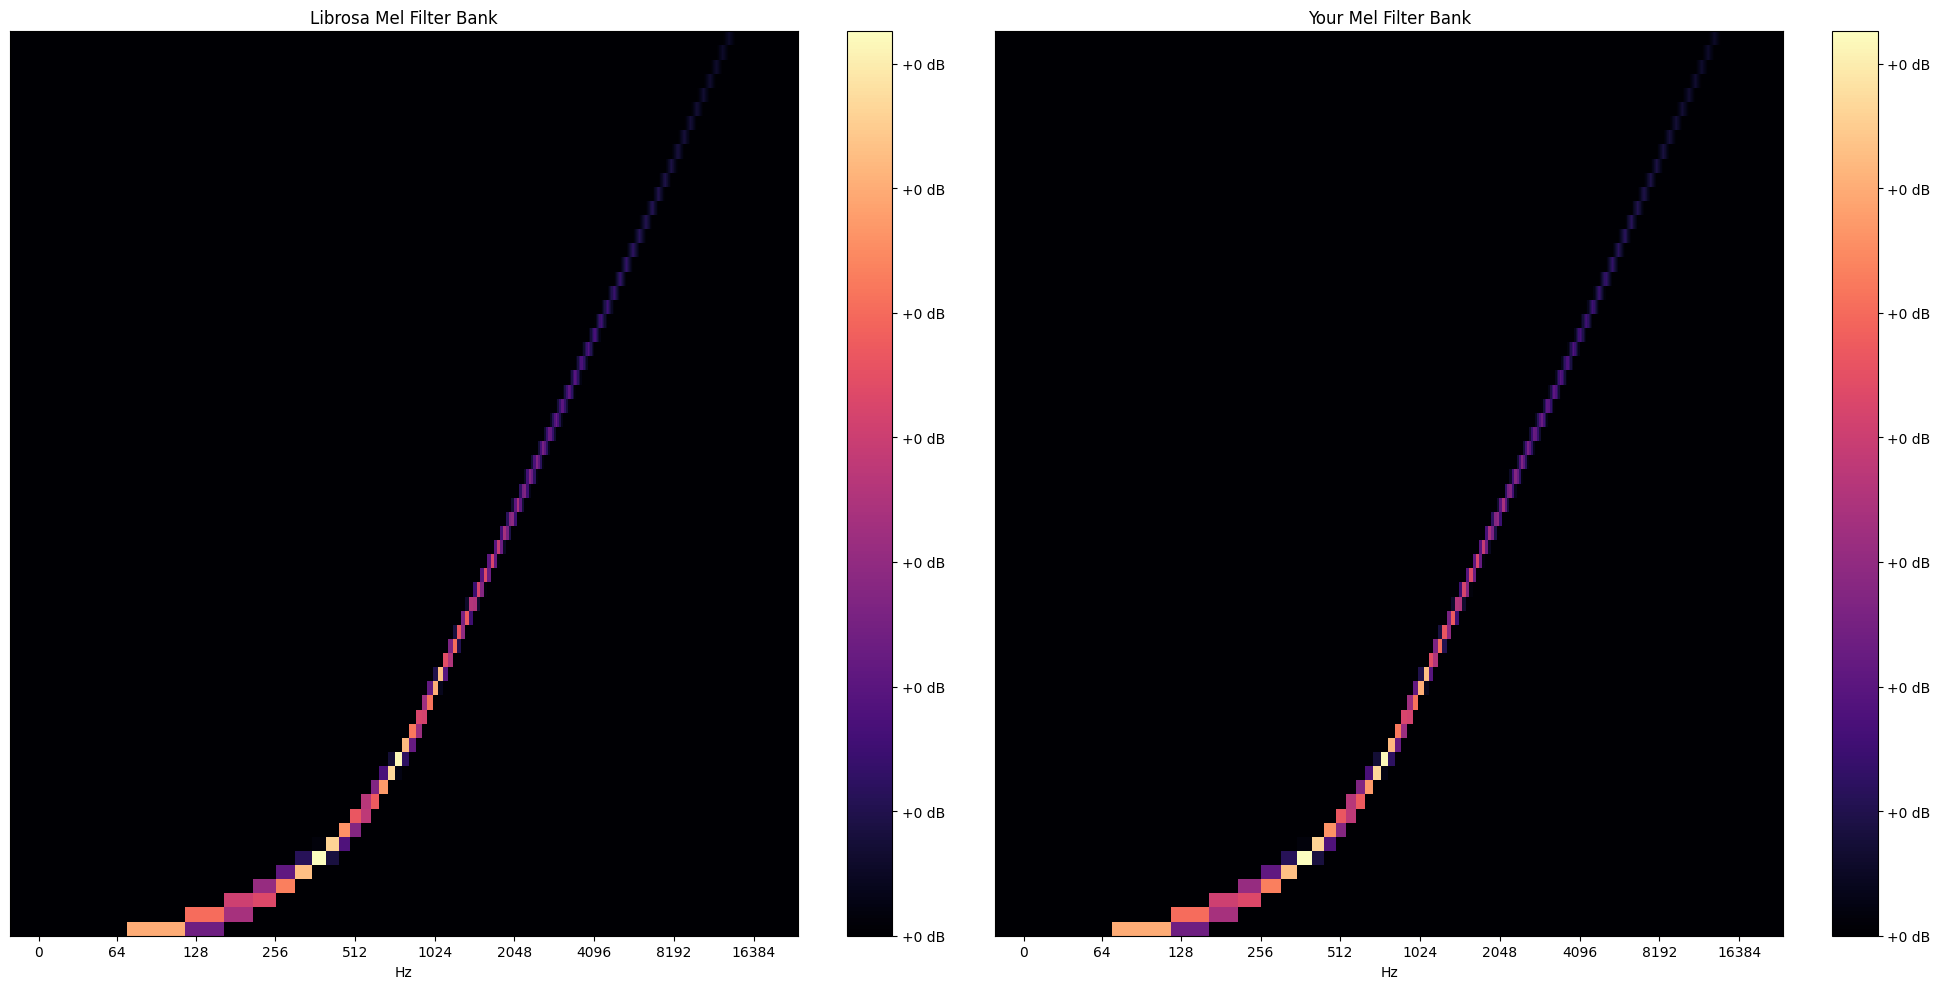

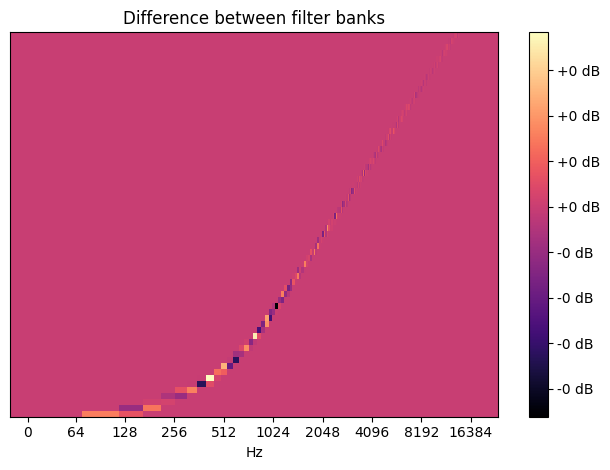

In [35]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from transformers.audio_utils import mel_filter_bank

# Configuration parameters
n_fft = 1024
n_mels = 64
sr = 48000
fmin = 50
fmax = 14000

# Your mel_filter_bank function needs to be defined as you have it

# Generate the Mel filter banks using both librosa and your custom function
librosa_filters = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)
your_mel_filters = mel_filter_bank(
    num_frequency_bins=513,
    num_mel_filters=64,
    max_frequency=14000,
    min_frequency=50,
    sampling_rate=48000,
    mel_scale='slaney',
    norm='slaney',
).transpose() # This should be the output of your custom function

# Plotting both filter banks for comparison
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa_filters, sr=sr, hop_length=512, x_axis='log')
plt.title('Librosa Mel Filter Bank')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(your_mel_filters, sr=sr, hop_length=512, x_axis='log')
plt.title('Your Mel Filter Bank')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

librosa.display.specshow(librosa_filters - your_mel_filters, sr=sr, hop_length=512, x_axis='log')
plt.title('Difference between filter banks')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


In [20]:
print(get_shapes_in_nests(audio_inputs))
print(audio_inputs["input_features"].dtype)
print(audio_inputs["is_longer"].dtype)
print(get_shapes_in_nests(manual_processed_input_features))
print(manual_processed_input_features["input_features"].dtype)
print(manual_processed_input_features["is_longer"].dtype)

input_features: torch.Size([32, 1, 1001, 64])
	is_longer: torch.Size([32, 1])
torch.float32
torch.bool
input_features: torch.Size([2, 1, 1001, 64])
	is_longer: torch.Size([2, 1])
torch.float32
torch.bool


### Actual Model Assessment
I went to all this trouble... does this model even work well?

In [25]:
ClapProcessor.from_pretrained(model_name)

loading configuration file preprocessor_config.json from cache at /Users/iveshenry18/.cache/huggingface/hub/models--laion--clap-htsat-unfused/snapshots/8fa0f1c6d0433df6e97c127f64b2a1d6c0dcda8a/preprocessor_config.json
Feature extractor ClapFeatureExtractor {
  "chunk_length_s": 10,
  "feature_extractor_type": "ClapFeatureExtractor",
  "feature_size": 64,
  "fft_window_size": 1024,
  "frequency_max": 14000,
  "frequency_min": 50,
  "hop_length": 480,
  "max_length_s": 10,
  "n_fft": 1024,
  "nb_frequency_bins": 513,
  "nb_max_frames": 1000,
  "nb_max_samples": 480000,
  "padding": "repeatpad",
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "ClapProcessor",
  "return_attention_mask": false,
  "sampling_rate": 48000,
  "top_db": null,
  "truncation": "rand_trunc"
}

loading file vocab.json from cache at /Users/iveshenry18/.cache/huggingface/hub/models--laion--clap-htsat-unfused/snapshots/8fa0f1c6d0433df6e97c127f64b2a1d6c0dcda8a/vocab.json
loading file merges.txt f

ClapProcessor:
- feature_extractor: ClapFeatureExtractor {
  "chunk_length_s": 10,
  "feature_extractor_type": "ClapFeatureExtractor",
  "feature_size": 64,
  "fft_window_size": 1024,
  "frequency_max": 14000,
  "frequency_min": 50,
  "hop_length": 480,
  "max_length_s": 10,
  "n_fft": 1024,
  "nb_frequency_bins": 513,
  "nb_max_frames": 1000,
  "nb_max_samples": 480000,
  "padding": "repeatpad",
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "ClapProcessor",
  "return_attention_mask": false,
  "sampling_rate": 48000,
  "top_db": null,
  "truncation": "rand_trunc"
}

- tokenizer: RobertaTokenizerFast(name_or_path='laion/clap-htsat-unfused', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, no

In [23]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

input_list = ["the sound of a gunshot", "the sound of a crowd", "the sound of a dog"]
tokenized_inputs = tokenizer(input_list, padding=True, return_tensors="pt")

text_model_outputs = text_model(**tokenized_inputs)
text_embeds = text_model_outputs.text_embeds

def assess_model(text_input, text_preprocessor, text_model, audio_input, audio_preprocessor, audio_model):
    text_embeds = text_model(**text_preprocessor(text_input)).text_embeds
    audio_embeds = audio_model(**audio_preprocessor(audio_input)).audio_embeds

    for i in range(len(text_input)):
        plt.subplot(len(text_input), 1,i+1)
        plt.title(f"{i}: {text_input[i]}")
        plt.imshow(text_embeds[i].reshape(8,-1).detach().numpy())
    plt.show()
    
    for i in range(len(audio_input[0:5])):
        plt.subplot(len(audio_input[0:5]), 1,i+1)
        plt.title(f"Audio {i}")
        plt.imshow(audio_embeds[i].reshape(8,-1).detach().numpy())
    plt.show()

    # Cosine Similarities

    norm_text_embeds = F.normalize(text_embeds, p=2, dim=1)
    norm_audio_embeds = F.normalize(audio_embeds, p=2, dim=1)

    cosine_similarities=F.cosine_similarity(text_embeds.unsqueeze(1), audio_embeds.unsqueeze(0), dim=2)
    plt.title("Cosine Similarities")
    plt.imshow(cosine_similarities.detach().numpy())
    plt.xlabel("Audio")
    plt.ylabel("Text")
    plt.show()

    # Top-3 and Bottom-3 Cosine Similarities for each text input
    for i in range(len(text_input)):
        print(text_input[i])
        print("Top 3")
        top_3_indices = cosine_similarities[i].argsort(descending=True)[0:3]
        print(top_3_indices.tolist())
        for j in top_3_indices:
            display(Audio(data=audio_sample[j], rate=44100))
        print("Bottom 3")
        bottom_3_indices = cosine_similarities[i].argsort(descending=False)[0:3]
        print(bottom_3_indices.tolist())
        for j in bottom_3_indices:
            display(Audio(data=audio_sample[j], rate=44100))
        print()
        
# Compare preprocessors

# from_pretrained tokenizer and processor
print("from_pretrained tokenizer and audio processor")
assess_model(
    text_input=["the sound of a gunshot", "the sound of a crowd", "the sound of a dog", "the sound of a bird", "the sound of applause", "the sound of a car"],
    text_preprocessor=lambda input: tokenizer(input, padding=True, return_tensors="pt"),
    text_model=text_model,
    audio_input=audio_sample,
    audio_preprocessor=lambda input: processor(audios=input, return_tensors="pt", sampling_rate=48000),
    audio_model=audio_model
)

# Reverse-engineered processor
print("Reverse-engineered audio processor")
assess_model(
    text_input=["the sound of a gunshot", "the sound of a crowd", "the sound of a dog", "the sound of a bird", "the sound of applause", "the sound of a car"],
    text_preprocessor=lambda input: tokenizer(input, padding=True, return_tensors="pt"),
    text_model=text_model,
    audio_input=audio_sample,
    audio_preprocessor=lambda input: pad_mel_dbifier(input),
    audio_model=audio_model
)

from_pretrained tokenizer and audio processor


KeyboardInterrupt: 

Not... nothing...